# Configuration

### Package Imports

In [94]:
from google.cloud import storage
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Dropout, Flatten, Dense, Activation, BatchNormalization, GlobalAvgPool2D, concatenate
from tensorflow.keras.layers import Add, ZeroPadding2D, AveragePooling2D, GaussianNoise, SeparableConv2D, Concatenate, LeakyReLU, Reshape, Lambda, Permute
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img
from tensorflow.keras.layers import add
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.callbacks import LearningRateScheduler, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import Sequence
from skimage.transform import resize
import matplotlib.pyplot as plt
import tensorflow as tf
import tqdm
import numpy as np
import pickle
from PIL import Image
import os
import random
from io import BytesIO
import io

### Directory Paths

In [36]:
config_bucket_name = 'open_images_v6_source_files'
config_prefix_name = 'yolo_example'
config_weight_path = f'{config_bucket_name}'

wt_path = 'D:/iod_yolo_data/weights/yolov2.weights'                      
train_image_folder = 'D:/iod_yolo_data/train/'
train_annot_folder = 'D:/iod_yolo_data/pascal_format/'
valid_image_folder = 'D:/iod_yolo_data/val/'
valid_annot_folder = 'D:/iod_yolo_data/pascal_format/'
model_save_path = 'D:/iod_yolo_data/mpdel_save/'
model_save_name = 'yolo_detector.hdf5'
dict_list_save_name = 'object_dict_list.txt'
dict_write_folder = 'D:/iod_yolo_data/pascal_format/'

### Model and Data Processing

In [82]:
LABELS = ['Television', 'Couch', 'Coffee table']
IMAGE_H, IMAGE_W = 256, 256
GRID_H,  GRID_W  = 8, 8
BOX              = 5
CLASS            = len(LABELS)
CLASS_WEIGHTS    = np.ones(CLASS, dtype='float32')
OBJ_THRESHOLD    = 0.3
NMS_THRESHOLD    = 0.3
ANCHORS          = [0.57273, 0.677385, 1.87446, 2.06253, 3.33843, 5.47434, 7.88282, 3.52778, 9.77052, 9.16828]
NO_OBJECT_SCALE  = 1.0
OBJECT_SCALE     = 5.0
COORD_SCALE      = 1.0
CLASS_SCALE      = 1.0
BATCH_SIZE       = 16
WARM_UP_BATCHES  = 0
TRUE_BOX_BUFFER  = 50

generator_config = {
    'IMAGE_H' : IMAGE_H, 
    'IMAGE_W' : IMAGE_W,
    'GRID_H'          : GRID_H,  
    'GRID_W'          : GRID_W,
    'BOX'             : BOX,
    'LABELS'          : LABELS,
    'CLASS'           : len(LABELS),
    'ANCHORS'         : ANCHORS,
    'BATCH_SIZE'      : BATCH_SIZE,
    'TRUE_BOX_BUFFER' : TRUE_BOX_BUFFER,
    'LAMBDA_NO_OBJECT' : 1.0,
    'LAMBDA_OBJECT':  5.0,
    'LAMBDA_COORD' : 1.0,
    'LAMBDA_CLASS' : 1.0
}

# Define Functions

### Google Cloud Storage Reading

In [106]:
def get_storage_file_names(prefix = '', bucket_name = config_bucket_name):
    """
    Get list of file names in a Google Cloud Storage bucket given a prefix (folder path)
    """
    client = storage.Client()
    bucket = client.get_bucket(bucket_name)
    bucket_files = [f for f in bucket.list_blobs()]
    file_list = list(bucket.list_blobs(prefix = prefix))
    file_names = [str(f).split(', ')[1] for f in file_list]
    return file_names

def read_gcs_pickle_file(file_name, bucket_name = config_bucket_name):
    """
    Read .pkl file from Google Cloud Storage bucket
    """
    client = storage.Client()
    bucket = client.get_bucket(config_bucket_name)
    blob = bucket.get_blob(file_name)
    blob = pickle.load(BytesIO(bytearray(blob.download_as_string())))
    return blob

def read_gcs_image_file(file_name, bucket_name = config_bucket_name):
    """
    Read image file from Google Cloud Storage bucket
    """
    client = storage.Client()
    bucket = client.get_bucket(config_bucket_name)
    blob = storage.Blob(file_name, bucket)
    blob = blob.download_as_string()
    blob = io.BytesIO(blob)
    img = np.asarray(Image.open(blob))
    return img

class ImageReader(object):
    def __init__(self, IMAGE_H, IMAGE_W, norm=None, bucket_name = config_bucket_name):
        self.IMAGE_H = IMAGE_H
        self.IMAGE_W = IMAGE_W
        self.norm    = norm
        self.bucket_name = bucket_name
    
    def fit(self,train_instance):
        """
        read in and resize the image, annotations are resized accordingly.
        
        -- Input -- 
        
        train_instance : dictionary containing filename, height, width and object
        
        {'filename': 'folder/subfolder/file_name.jpg',
         'height':   333,
         'width':    500,
         'object': [{'name': 'bird',
                     'xmax': 318,
                     'xmin': 284,
                     'ymax': 184,
                     'ymin': 100},
                    {'name': 'bird', 
                     'xmax': 198, 
                     'xmin': 112, 
                     'ymax': 209, 
                     'ymin': 146}]
        }
        
        """
        if not isinstance(train_instance,dict):
            train_instance = {'filename':train_instance}
                
        image_name = train_instance['filename']
        image = read_gcs_image_file(file_name = image_name, bucket_name = self.bucket_name)
        h, w, c = image.shape
        image = image[:,:,::-1]
        image = resize(image, (IMAGE_H, IMAGE_W))
            
        if 'object' in train_instance.keys():
            all_objs = copy.deepcopy(train_instance['object'])     
            for obj in all_objs:
                for attr in ['xmin', 'xmax']:
                    obj[attr] = int(obj[attr] * float(self.IMAGE_W) / w)
                    obj[attr] = max(min(obj[attr], self.IMAGE_W), 0)

                for attr in ['ymin', 'ymax']:
                    obj[attr] = int(obj[attr] * float(self.IMAGE_H) / h)
                    obj[attr] = max(min(obj[attr], self.IMAGE_H), 0)
        else:
            return image
        return image, all_objs

### Image Manipulation Functions

In [ ]:
def normalize(image):
    """Normalize numpy image array by dividing floats by 255."""
    return image / 255.

In [98]:
train_images = read_gcs_pickle_file('yolo_example/pascal_format/object_dict_list.pkl')
for ti in train_images:
    ti['filename'] = 'yolo_example/train/' + ti['filename'].split('/')[-1]

In [102]:
train_images[0:3]

[{'object': [{'name': 'Piano',
    'xmin': 27,
    'ymin': 50,
    'xmax': 167,
    'ymax': 199}],
  'filename': 'yolo_example/train/2aace487f850a4a3.jpeg',
  'width': 200,
  'height': 200},
 {'object': [{'name': 'Couch',
    'xmin': 0,
    'ymin': 87,
    'xmax': 199,
    'ymax': 199}],
  'filename': 'yolo_example/train/2a856a75436d6e79.jpeg',
  'width': 200,
  'height': 200},
 {'object': [{'name': 'Piano',
    'xmin': 52,
    'ymin': 58,
    'xmax': 151,
    'ymax': 118}],
  'filename': 'yolo_example/train/6eda6d0714a0c881.jpeg',
  'width': 200,
  'height': 200}]

In [97]:
train_images[0].get('filename').split('/')[-1]

'2aace487f850a4a3.jpeg'

In [84]:
temp = get_storage_file_names(prefix = 'yolo_example/train/')

In [103]:
temp_img = read_gcs_image_file('yolo_example/train/0000615b5a80f660.jpeg')

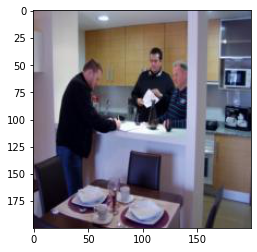

In [105]:
plt.imshow(temp_img)

In [33]:
temp = get_storage_file_names(prefix = 'yolo_example/pascal_format/', bucket_name = config_bucket_name)

In [34]:
temp[0]


'yolo_example/pascal_format/object_dict_list.txt.txt'

In [ ]:
import csv
from io import StringIO

from google.cloud import storage

storage_client = storage.Client()
bucket = storage_client.get_bucket(YOUR_BUCKET_NAME)

blob = bucket.blob(YOUR_FILE_NAME)
blob = blob.download_as_string()
blob = blob.decode('utf-8')

blob = StringIO(blob)  #tranform bytes to string here